<a href="https://colab.research.google.com/github/ashokdahal/BurntAreaMapping_AIA/blob/main/FCN_DK3_BAM_0_001_300_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Burnt Area Mapping using FCNN and the Sentinel 2 Images using FCN-DK2</h1>
Code Author: Ashok Dahal 

***This code is developed for the assignment of the Advanced Image Analysis Course, and hence, has not been peer reviewd and verfied, use at your own risk***

# Load libraries and prepare connect to data folders

In [1]:
#connect to the goolge drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import the required Libraries
import os
import numpy as np
import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from google.colab import drive
import tensorflow as tf

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from keras import backend as K
from keras.optimizers import SGD, Adadelta

import tensorflow.python.keras.backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session
from keras.layers import LeakyReLU
import pickle
import matplotlib.pyplot as plt 
import sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Define File directories
Data_folder = "/content/drive/My Drive/AIA_colab/Forest_fire/Classified Tiles"
IMAGE_PATH = os.path.join(Data_folder, "ImageNBR")
LABEL_PATH = os.path.join(Data_folder, "Label")

#Load and Prepare the required dataset

In [10]:
#Create list of sentinel images 
image_list={}
for f in sorted(os.listdir(IMAGE_PATH)):
    fdir = os.path.join(IMAGE_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        image_data=gdal.Open(fdir)
        bands = [image_data.GetRasterBand(image_data.RasterCount).ReadAsArray()]
        image_list[imgtype] = np.stack(bands, axis=2)

In [12]:
#Create list of Lables
label_list={}
for f in sorted(os.listdir(LABEL_PATH)):
    fdir = os.path.join(LABEL_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        label_data=gdal.Open(fdir)
        bands = [label_data.GetRasterBand(label_data.RasterCount).ReadAsArray()]
        label_list[imgtype] = np.stack(bands, axis=2)

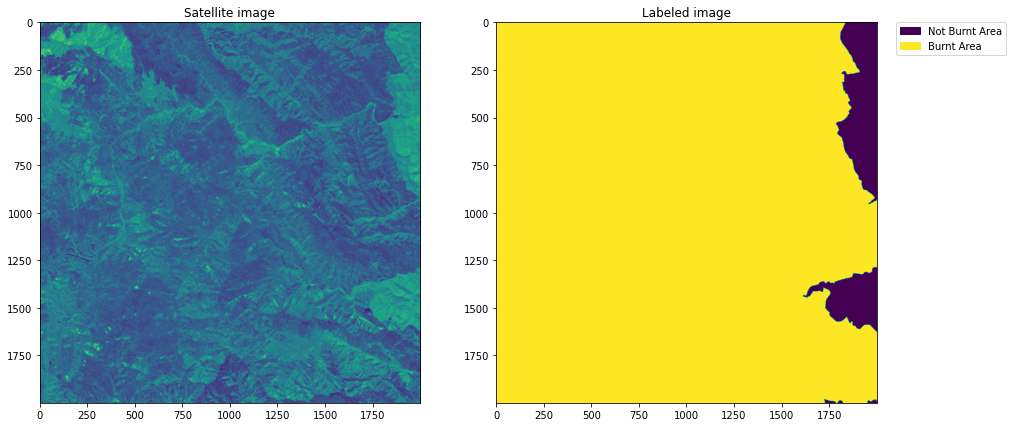

In [13]:
#visualize both images 
sample_image="00004"
sample_label="00004"

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)

    im = axarr[0].imshow(data[:,:,0])
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["Not Burnt Area", "Burnt Area"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(image_list[sample_image],label_list[sample_label])


In [14]:
#convert data into smaller patches and keras usable formats

PATCHSIZE = 128
NBANDS = image_list["00001"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
train_areas = ["00000", "00002", "00003","00004","00005","00010","00012","00013"] #00001 and 00011 are used as test
for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-informal settlement classes as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 1800 number of training patches


In [15]:
nb_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))
yb_px=len(Ytrain[Ytrain==2])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))
print("there are %f percent pixels of burnt pixels and %f percent pixels of not burnt pixels" % (yb_px*100,nb_px*100) )

there are 33.545169 percent pixels of burnt pixels and 66.454831 percent pixels of not burnt pixels


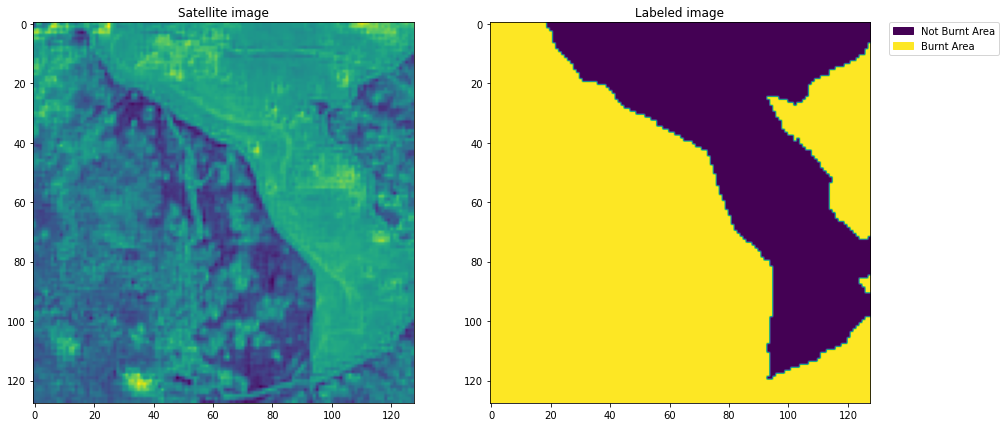

In [16]:
#Visualize the Patches of Image
PATCH_NO = 490
visualize_data(Xtrain[PATCH_NO],Ytrain[PATCH_NO])

Convert Label data to categorical

In [17]:
def to_categorical_4d(y, nc):
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y
# transform target arrays to one-hot encodings
Ytrain = to_categorical_4d(Ytrain, 2)

# Create a FCNN model and train it

In [29]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))

NUMBER_BANDS = 1
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 300 
nclasses=2
def build_FCN(optimizer, nrows, ncols, nbands,nclasses):
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((2, 2)))
    model.add(MaxPooling2D(
              pool_size=(5, 5),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((4, 4)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(2, 2)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((4, 4)))
    model.add(MaxPooling2D(
            pool_size=(9, 9),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((6, 6)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(3, 3)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((6, 6)))
    model.add(MaxPooling2D(
            pool_size=(13, 13),
            strides=(1, 1)
    ))
    model.add(Convolution2D(
              filters=nclasses,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
fcn = build_FCN(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS,NUMBER_CLASSES)

fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m]) #'adam'

In [ ]:
fcn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_6 (ZeroPaddin (None, 132, 132, 7)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      5632      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 132, 132, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 136, 136, 32)     

Train the Model

In [30]:
def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=NUMBER_EPOCHS,
                     validation_split=0.20,
                     verbose=2
                    )
    return hist

history = train(fcn, Xtrain, Ytrain)

Epoch 1/300
45/45 - 9s - loss: 0.2151 - acc: 0.9214 - f1_m: 0.9214 - precision_m: 0.9214 - recall_m: 0.9214 - val_loss: 0.3074 - val_acc: 0.8360 - val_f1_m: 0.8463 - val_precision_m: 0.8463 - val_recall_m: 0.8463
Epoch 2/300
45/45 - 9s - loss: 0.1624 - acc: 0.9483 - f1_m: 0.9483 - precision_m: 0.9483 - recall_m: 0.9483 - val_loss: 0.4670 - val_acc: 0.8261 - val_f1_m: 0.8370 - val_precision_m: 0.8370 - val_recall_m: 0.8370
Epoch 3/300
45/45 - 9s - loss: 0.1625 - acc: 0.9462 - f1_m: 0.9462 - precision_m: 0.9462 - recall_m: 0.9462 - val_loss: 0.5279 - val_acc: 0.8261 - val_f1_m: 0.8370 - val_precision_m: 0.8370 - val_recall_m: 0.8370
Epoch 4/300
45/45 - 9s - loss: 0.1601 - acc: 0.9478 - f1_m: 0.9478 - precision_m: 0.9478 - recall_m: 0.9478 - val_loss: 0.7358 - val_acc: 0.8261 - val_f1_m: 0.8370 - val_precision_m: 0.8370 - val_recall_m: 0.8370
Epoch 5/300
45/45 - 9s - loss: 0.1518 - acc: 0.9518 - f1_m: 0.9518 - precision_m: 0.9518 - recall_m: 0.9518 - val_loss: 0.6740 - val_acc: 0.8261 - v

# Visualize the Training Output and Save the model

Visualize Learning Curve

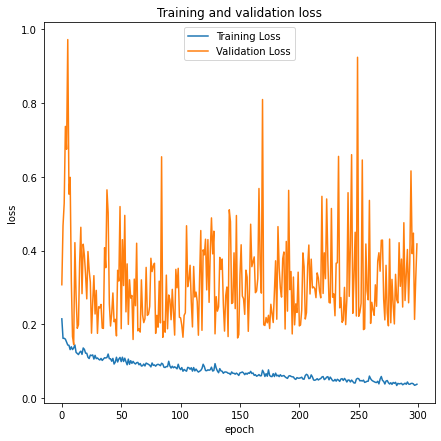

In [48]:
# plot learning curve
plt.figure(figsize=(7,7))
plt.plot(history.history["loss"],label='Training Loss')
plt.title("Training and validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(history.history["val_loss"],label='Validation Loss')
plt.legend()
plt.show()

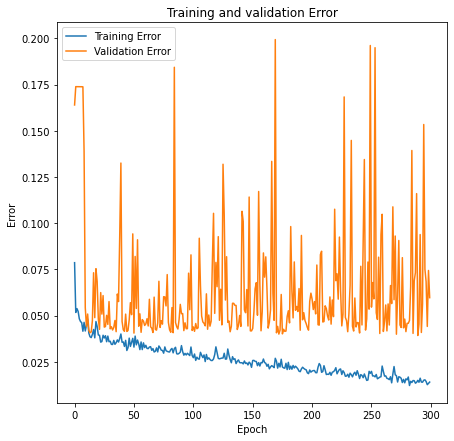

In [50]:
# plot learning curve
plt.figure(figsize=(7,7))
plt.plot(1-np.array(history.history["acc"]),label='Training Error')
plt.title("Training and validation Error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.plot(1-np.array(history.history["val_acc"]),label='Validation Error')
plt.legend()
plt.show()

Save output

In [58]:
# save the trained network
import imp, h5py
imp.reload(h5py)
model_fname = "/content/drive/My Drive/AIA_colab/Forest_fire/Classified Tiles/FCN-DK3_BAM_0.001_300_BR.hdf5"
fcn.save(model_fname)

# Test the Accuracy of the Model

In [59]:
Xtest = image_list["00001"]
Ytest = label_list["00001"]
cut = 128
overlap = 96

In [61]:
def evaluate_predictions(Xtest,cut, overlap, Ytest):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = fcn
        
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map
predictions_FCN = evaluate_predictions(Xtest, cut, overlap, Ytest)

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Strip number: 5
Strip number: 6
Strip number: 7
Strip number: 8
Strip number: 9
Strip number: 10
Strip number: 11
Strip number: 12
Strip number: 13
Strip number: 14
Last hit!
Strip number: 15
Last hit!


In [62]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score

# set color codes of the classes
_others = [221, 61, 14]
_slums = [200, 199, 219]
ccolors = (_slums, _others)
NROWS, NCOLS, NBANDS = Xtest.shape


def print_map(predictions, idxarray, filename=None, title=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename,
                                                             NCOLS,
                                                             NROWS,
                                                             NUMBER_CLASSES,
                                                             gdal.GDT_Byte)
        for i in range(NUMBER_CLASSES):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])


def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM


def cartesian(arrays, out=None):
    """Utility function to create cartesian image coordinates."""
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


IndexError: ignored

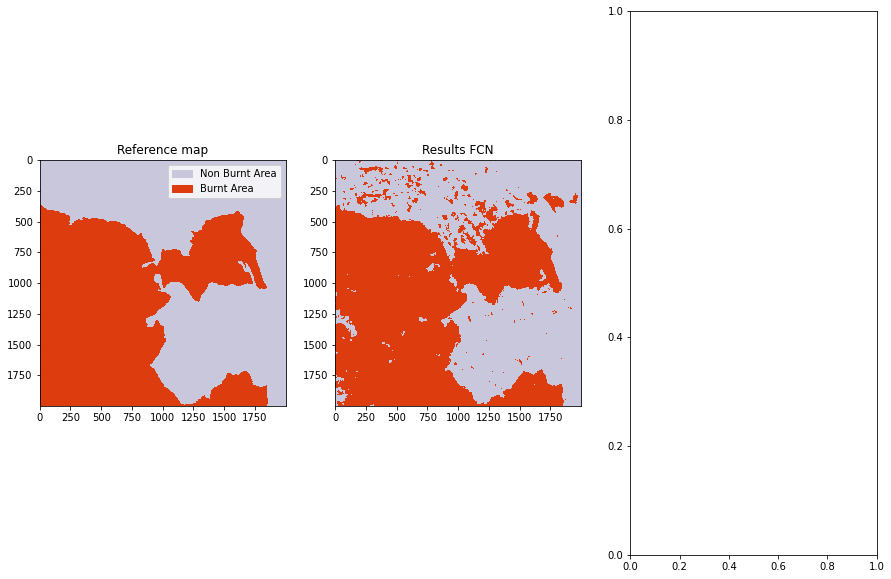

In [63]:
#plot Refrence Map
f, axarr = plt.subplots(1,3)
predictions = predictions_FCN
norm_ccolors = np.array(ccolors)/255.0


fig = axarr[0]
cmap = colors.ListedColormap(norm_ccolors)
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = Ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
fig.imshow(labels, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
fig.set_title("Reference map")

ax= axarr[1]
ax.imshow(predictions, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Results FCN")

rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = [ "Non Burnt Area","Burnt Area"]
#Create legend from custom artist/label lists
fig.legend(rectangles, classes)
labels = labels.astype("uint8")

data=Xtest
data = data[:, :, 0:3]
_ = data[:, :, 0].copy()
data[:, :, 0] = data[:, :, 2]
data[:, :, 2] = _
data = data.astype(np.float)
for i in range(data.shape[2]):
    p2, p98 = np.percentile(data[:, :, i], (2, 98))
    data[:, :, i] = exposure.rescale_intensity(data[:, :, i],in_range=(p2, p98))

plt_sat=axarr[2]
a=plt_sat.set_title("Satellite image")
_=plt_sat.imshow(data)



In [64]:
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
print("Accuracy metrics of FCN results")
print("Overall Accuracy: %f" % OA)
#print("F1_score: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of Burnt Area: %f" % PA_bldg)
print("PA of Not Burnt Area: %f" % PA_rd)


Accuracy metrics of FCN results
Overall Accuracy: 0.934560
PA of Burnt Area: 0.897593
PA of Not Burnt Area: 0.975782
